# <h1 align = "center"> Keras Models</h1>

The goal for this analysis is to predict if a review rates the movie positively or negatively. Inside this dataset, there are 25,000 labelled movies reviews for training, 50,000 unlabeled reviews for training, and 25,000 reviews for testing.
<a href="https://imgur.com/FfdEBRz"><img src="https://i.imgur.com/FfdEBRzm.png" title="source: imgur.com" align="right"></a>
- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- Contains 25000 positive and 25000 negative reviews
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)


This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow
> **Here, we use Keras Sequential API to train and test simple neural networks to classify sentiments of reviews by inputting tfidf features**

## <h2 align = "center">Dependencies</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier


import warnings
warnings.filterwarnings('ignore')

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

2023-05-20 22:00:37.425567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Version:  2.10.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


2023-05-20 22:00:40.820101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
'''
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

"\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [3]:
movies = pd.read_csv('/Users/mohitkapoor/Downloads/New code/imdb_data.csv')
movies.sample(7)

,review,sentiment
10303,This is standard fare from a director who as l...,positive
15109,"Once you can get past the film's title, ""Pecke...",positive
39341,"L'OSSESSA, also known as THE TORMENTED or THE ...",positive
2447,Sometimes they get lucky and have a hit on the...,positive
23676,I really truly enjoyed this movie. (Which is w...,positive
10043,I cannot say this movie is a disappointment be...,positive
5693,I noticed this movie was getting trashed well ...,positive


> **Binarize the sentiment column**

In [4]:
le = LabelEncoder()
movies['sentiment'] = le.fit_transform(movies['sentiment'])
movies.sample(7)

,review,sentiment
46201,I gave this movie a four-star rating for a few...,0
44078,Yeah this films is tops. Cant recommend it mor...,1
29928,The first full-length film featuring the Aardm...,1
15353,xica da Silva is one of the best Brazilians op...,1
10458,This is one of the best Czech movies I have ev...,1
19015,"""Everything is Illuminated"" is like viewing a ...",1
19029,An excellent thriller of all time. Vijay Anand...,1


 > **Vectorize the reviews text**

In [5]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ
    }

    transformed_texts = TfidfVectorizer(**kwargs).fit_transform(texts)
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts

vect_reviews = ngram_vectorize(movies['review'], movies['sentiment'])
vect_reviews.shape

(50000, 20000)

> **Split the data**

In [6]:
X = vect_reviews.toarray()
y = (np.array(movies['sentiment']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")

Train dataset shape: (40000, 20000), 
Test dataset shape: (10000, 20000)


## <h2 align = "center">Modeling the data</h2>

In [7]:
simple_log = LambdaCallback(
    on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Loss: {l['val_loss']:.5f}", end =" >|> \n" ))

early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, 
                              restore_best_weights=True)
sns.set()
def plot_learning_curve(hist):
    plt.figure(figsize=(5,5))
    if 'accuracy' in hist.history:
        train = hist.history['accuracy']
        val = hist.history['val_accuracy']
    else:
        train = hist.history['acc']
        val = hist.history['val_acc']
    epochs_run = range(1,len(train) + 1)
    sns.lineplot(x=epochs_run, y=train, marker='o', color='coral', label='Training Accuracy')
    sns.lineplot(x=epochs_run, y=val, marker='>', color='green', label='Validation Accuracy')
    plt.title("Accuracies vs. Epochs", fontsize = 20)
    plt.legend()
    plt.show()


In [8]:
input_shape = X_train.shape[1:]

model = Sequential([    
    Dense(64, activation = 'relu', input_shape = input_shape),
    Dense(1, activation = 'sigmoid')
])

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1280064   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [9]:
epochs = 20

h = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = [early_stop, simple_log],
    verbose = False)
print("\nDone.")

 ~| Epoch: 1 | Validation Loss: 0.18449 >|> 
 ~| Epoch: 2 | Validation Loss: 0.17416 >|> 
 ~| Epoch: 3 | Validation Loss: 0.18565 >|> 

Done.


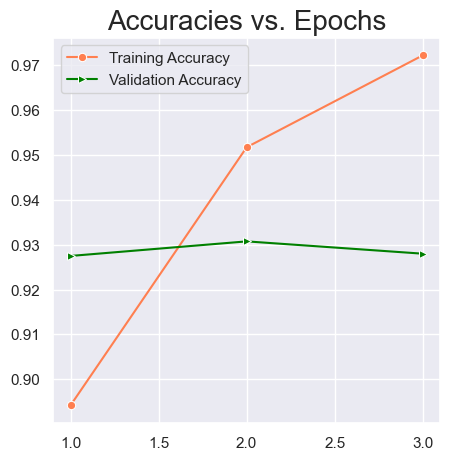

In [10]:
plot_learning_curve(h)

> **Classic case of overfitting**

In [11]:
loss, acc = model.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

313/313 [==============================] - 1s 2ms/step - loss: 0.1923 - accuracy: 0.9248
Testing Accuracy:  92.47999787330627


> **Trying dropout regularization**

In [12]:
input_shape = X_train.shape[1:]
from tensorflow.keras.regularizers import l2

model2 = Sequential([    
    Dense(20, activation = 'relu', input_shape = input_shape, kernel_regularizer=l2()),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model2.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                400020    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 400,041
Trainable params: 400,041
Non-trainable params: 0
_________________________________________________________________


In [13]:
epochs = 10

h2 = model2.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = [early_stop, simple_log],
    verbose = False)
print("Done.")

 ~| Epoch: 1 | Validation Loss: 0.67353 >|> 
 ~| Epoch: 2 | Validation Loss: 0.63628 >|> 
 ~| Epoch: 3 | Validation Loss: 0.60331 >|> 
 ~| Epoch: 4 | Validation Loss: 0.57269 >|> 
 ~| Epoch: 5 | Validation Loss: 0.54912 >|> 
 ~| Epoch: 6 | Validation Loss: 0.53062 >|> 
 ~| Epoch: 7 | Validation Loss: 0.51582 >|> 
 ~| Epoch: 8 | Validation Loss: 0.50441 >|> 
 ~| Epoch: 9 | Validation Loss: 0.49161 >|> 
 ~| Epoch: 10 | Validation Loss: 0.48200 >|> 
Done.


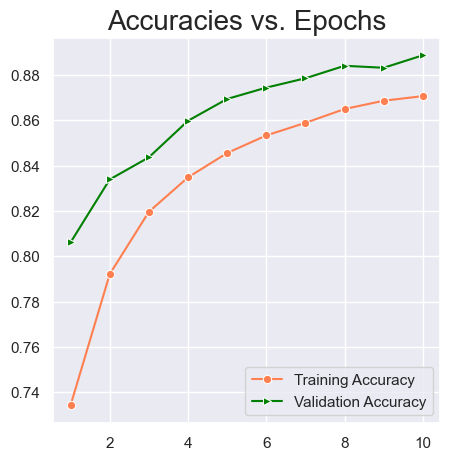

In [15]:
plot_learning_curve(h2)

In [16]:
loss, acc = model2.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

313/313 [==============================] - 1s 1ms/step - loss: 0.4874 - accuracy: 0.8861
Testing Accuracy:  88.60999941825867


In [17]:
input_shape = X_train.shape[1:]
from tensorflow.keras.regularizers import l2

model3 = Sequential([   
    Dense(64, activation = 'relu', input_shape = input_shape),
    Dropout(0.2),
    Dense(16, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model3.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1280064   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,281,121
Trainable params: 1,281,121
Non-trainable params: 0
_________________________________________________________________


In [18]:
epochs = 20

h3 = model3.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = [early_stop, simple_log],
    verbose = False
)
print("\nDone.")

 ~| Epoch: 1 | Validation Loss: 0.18333 >|> 
 ~| Epoch: 2 | Validation Loss: 0.18673 >|> 

Done.


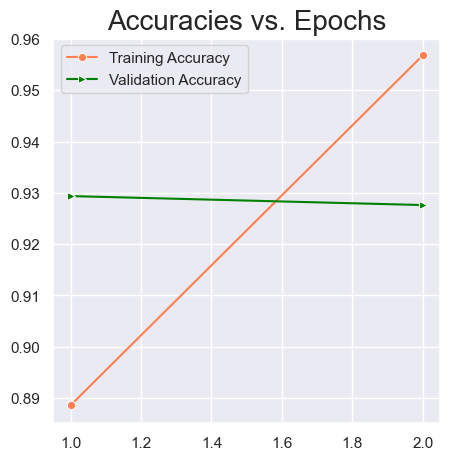

In [19]:
plot_learning_curve(h3)

In [20]:
loss, acc = model3.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

313/313 [==============================] - 1s 2ms/step - loss: 0.1982 - accuracy: 0.9231
Testing Accuracy:  92.30999946594238


### <h3 align = "center">Optimize activations and learning rate</h3>

In [21]:
def create_model(learning_rate=0.01, activation='relu'):
    opt = tf.keras.optimizers.Adam(lr=learning_rate)
    model = Sequential()
    model.add(Dense(64, input_shape=input_shape, activation=activation)),
    Dropout(0.2),
    model.add(Dense(16, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold


# Create a KerasClassifier
model = KerasClassifier(build_fn = create_model)

# Define the parameters to try out
params = {'activation': ['relu'],'epochs': [3, 5, 10], 
          'learning_rate': [0.1, 0.01, 0.001], 'batch_size': [64, 128, 256]}

# Create a randomize search cv object passing in the parameters to try
random_search = RandomizedSearchCV(model, param_distributions = params, cv = KFold(2))

# Fit the random search cv object to the training data
random_search.fit(X_train, y_train, verbose = True)


Epoch 1/10
157/157 [==============================] - 2s 9ms/step - loss: 0.2799 - accuracy: 0.8784
Epoch 2/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0827 - accuracy: 0.9717
Epoch 3/10
157/157 [==============================] - 1s 8ms/step - loss: 0.0324 - accuracy: 0.9896
Epoch 4/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0110 - accuracy: 0.9968
Epoch 5/10
157/157 [==============================] - 1s 7ms/step - loss: 0.0030 - accuracy: 0.9992
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 6.8129e-04 - accuracy: 0.9999
Epoch 7/10
157/157 [==============================] - 1s 7ms/step - loss: 8.6039e-05 - accuracy: 1.0000
Epoch 8/10
157/157 [==============================] - 1s 8ms/step - loss: 4.1386e-05 - accuracy: 1.0000
Epoch 9/10
157/157 [==============================] - 1s 9ms/step - loss: 2.7478e-05 - accuracy: 1.0000
Epoch 10/10
157/157 [==============================] - 1s 5ms/step - loss: 0.8833 - 

313/313 [==============================] - 2s 5ms/step - loss: 0.0042 - accuracy: 0.9984
Epoch 9/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0127 - accuracy: 0.9962
Epoch 10/10
313/313 [==============================] - 1s 3ms/step - loss: 0.6170 - accuracy: 0.9021
Epoch 1/10
313/313 [==============================] - 2s 5ms/step - loss: 0.2520 - accuracy: 0.8958
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0756 - accuracy: 0.9730
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0356 - accuracy: 0.9865
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0203 - accuracy: 0.9924
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0104 - accuracy: 0.9961
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0093 - accuracy: 0.9966
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0080 - accuracy: 0.9969
Epoch 8/10

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7feb4a13be20>,
                   param_distributions={'activation': ['relu'],
                                        'batch_size': [64, 128, 256],
                                        'epochs': [3, 5, 10],
                                        'learning_rate': [0.1, 0.01, 0.001]})

In [24]:
# Get the best parameters
best_params = random_search.best_params_
print(best_params)

{'learning_rate': 0.001, 'epochs': 5, 'batch_size': 256, 'activation': 'relu'}


In [25]:
best_random = random_search.best_estimator_ 
pred = best_random.predict(X_test)
pred_train = best_random.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

1250/1250 [==============================] - 2s 2ms/step
Training set Accuracy:  99.6275
Test set Accuracy:  92.02


In [26]:
def create_model(drop_out=0.2, units=64, learning_rate = 0.001):
    model = Sequential()
    model.add(Dropout(drop_out, input_shape=input_shape))
    model.add(Dense(units, activation = 'relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [28]:
model_params = KerasClassifier(build_fn = create_model)

params = {'drop_out': [0.2, 0.15, 0.1, 0.01], 'units': [60, 70, 90],
          'learning_rate': [0.001], 'batch_size': [128], 'epochs' : [5]}

# Create a randomize search cv object passing in the parameters to try
random_params = RandomizedSearchCV(model_params, param_distributions = params, cv = KFold(2))

In [29]:
random_params.fit(X_train, y_train, verbose = True)

Epoch 1/5
157/157 [==============================] - 2s 12ms/step - loss: 0.4978 - accuracy: 0.8390
Epoch 2/5
157/157 [==============================] - 2s 11ms/step - loss: 0.2522 - accuracy: 0.9189
Epoch 3/5
157/157 [==============================] - 2s 11ms/step - loss: 0.1766 - accuracy: 0.9426
Epoch 4/5
157/157 [==============================] - 2s 11ms/step - loss: 0.1377 - accuracy: 0.9559
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1918 - accuracy: 0.9233
Epoch 1/5
157/157 [==============================] - 2s 12ms/step - loss: 0.4999 - accuracy: 0.8503
Epoch 2/5
157/157 [==============================] - 2s 12ms/step - loss: 0.2533 - accuracy: 0.9168
Epoch 3/5
157/157 [==============================] - 2s 12ms/step - loss: 0.1809 - accuracy: 0.9406
Epoch 4/5
157/157 [==============================] - 2s 12ms/step - loss: 0.1419 - accuracy: 0.9542
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.1879 - accuracy: 0.9247
Ep

157/157 [==============================] - 1s 8ms/step - loss: 0.1862 - accuracy: 0.9251
Epoch 1/5
157/157 [==============================] - 3s 16ms/step - loss: 0.4678 - accuracy: 0.8658
Epoch 2/5
157/157 [==============================] - 2s 15ms/step - loss: 0.2238 - accuracy: 0.9258
Epoch 3/5
157/157 [==============================] - 2s 15ms/step - loss: 0.1526 - accuracy: 0.9513
Epoch 4/5
157/157 [==============================] - 2s 15ms/step - loss: 0.1122 - accuracy: 0.9671
Epoch 5/5
157/157 [==============================] - 1s 8ms/step - loss: 0.1945 - accuracy: 0.9233
Epoch 1/5
157/157 [==============================] - 3s 16ms/step - loss: 0.4728 - accuracy: 0.8665
Epoch 2/5
157/157 [==============================] - 2s 16ms/step - loss: 0.2262 - accuracy: 0.9262
Epoch 3/5
157/157 [==============================] - 2s 16ms/step - loss: 0.1566 - accuracy: 0.9499
Epoch 4/5
157/157 [==============================] - 2s 16ms/step - loss: 0.1163 - accuracy: 0.9654
Epoch 5/5
15

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7feb49bcdbd0>,
                   param_distributions={'batch_size': [128],
                                        'drop_out': [0.2, 0.15, 0.1, 0.01],
                                        'epochs': [5], 'learning_rate': [0.001],
                                        'units': [60, 70, 90]})

In [30]:
random_params.best_estimator_

In [31]:
random_params.best_params_

{'units': 90,
 'learning_rate': 0.001,
 'epochs': 5,
 'drop_out': 0.2,
 'batch_size': 128}

In [32]:
best_random = random_params.best_estimator_ 
pred = best_random.predict(X_test)
pred_train = best_random.predict(X_train)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)
print("Test set Accuracy: ", accuracy_score(pred, y_test)*100)

1250/1250 [==============================] - 3s 2ms/step
Training set Accuracy:  98.00999999999999
Test set Accuracy:  92.86999999999999


313/313 [==============================] - 1s 2ms/step
Accuracy: 0.9287
Precision: 0.9287622210263963
Recall: 0.9287
F1 Score: 0.9286987800467403
Confusion Matrix:
[[4658  327]
 [ 386 4629]]


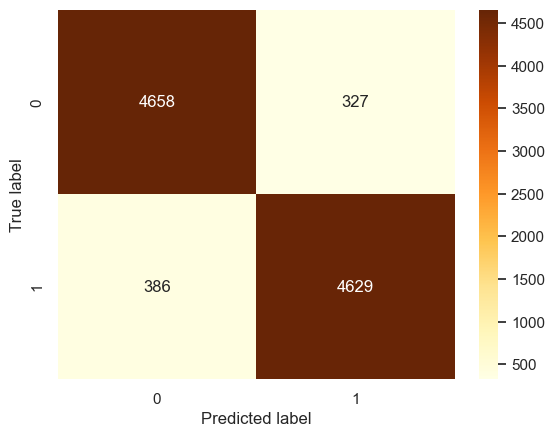

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = best_random.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=best_random.classes_, yticklabels=best_random.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

In [36]:
input_shape = X_train.shape[1:]

model4 = Sequential([ 
    Dropout(0.2, input_shape=input_shape),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(lr=0.002)
model4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

model4.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_66 (Dropout)        (None, 20000)             0         
                                                                 
 dense_112 (Dense)           (None, 64)                1280064   
                                                                 
 dropout_67 (Dropout)        (None, 64)                0         
                                                                 
 dense_113 (Dense)           (None, 1)                 65        
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [37]:
epochs = 150
batch_size = 128


h4 = model4.fit(X_train, y_train, epochs=epochs,
               validation_split = 0.2,
               callbacks=[early_stop, simple_log],
               verbose=False,
               batch_size=batch_size)
print("Done.")

 ~| Epoch: 1 | Validation Loss: 0.20361 >|> 
 ~| Epoch: 2 | Validation Loss: 0.17547 >|> 
 ~| Epoch: 3 | Validation Loss: 0.17244 >|> 
 ~| Epoch: 4 | Validation Loss: 0.18172 >|> 
Done.


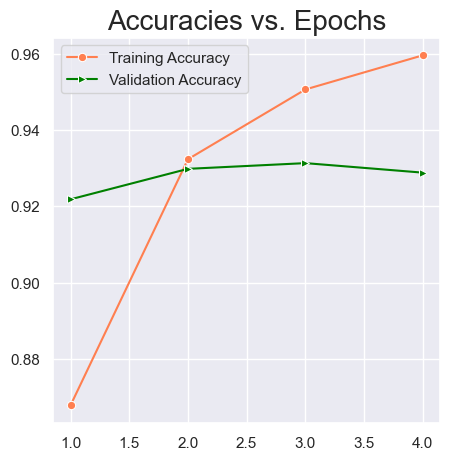

In [38]:
plot_learning_curve(h4)

In [39]:
loss, acc = model4.evaluate(X_test, y_test)
print("Testing Accuracy: ", acc*100)

313/313 [==============================] - 1s 2ms/step - loss: 0.1893 - acc: 0.9255
Testing Accuracy:  92.5499975681305
